<a href="https://colab.research.google.com/github/Nozasp/Mooc_Python/blob/master/PC_PytorchOptimization_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [114]:
import sys
import os, sys #os for global variable
from google.colab import drive

drive.mount('/content/gdrive')
path_to_module = "/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src/PC_param.ipynb" #path_to_module = '/content/gdrive/MyDrive/ColabNotebooks/PC_param.ipynb'

#os.symlink('/content/gdrive/MyDrive/Github/PredictiveCoding/main/src', path_to_module)
sys.path.append(path_to_module) # or sys.path.insert(0, path_to_module)
%cd /content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
!pwd

!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
/content/gdrive/MyDrive/Github/PredictiveCoding/main/Src
PC_filters.ipynb    PC_Main.ipynb	     PC_param.ipynb		 PC_StimuliSequence.ipynb
PC_functions.ipynb  PC_Main_toPytorch.ipynb  PC_Step_8_loopJeiJii.ipynb


In [115]:
!pip install import_ipynb
#!pip install --target=$/content/gdrive/MyDrive/Github/PredictiveCoding/Lib/site-packages import_ipynb
!pip install lmfit

In [116]:
from lmfit import Model
import import_ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F #F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
#from scipy.sparse import identity

# Functions

In [117]:
# 2- Input/Output function
def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))#, param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
      plt.xlim(xlim_ar) #[0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()

def plot_s(range_sim, S_e, S_i, param, xlim_ar = None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"#, I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"#, I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei)) #, param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie)) #, round(param.I2, 2)
    if xlim_ar != None:
      plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    #plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()

# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)

    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()

In [118]:

# Filters gauss and Dog and LoG

def gaussian_filter(s, N):
    k = np.arange(1, N+1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis])**2 / (2 * s**2))
    gaussW2 = gaussW / (.009**2 / np.max(gaussW)) #1
    return gaussW2

def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N+1)
    gaussIn =  np.exp(-(k - k[:, np.newaxis])**2 / (2 * sIn**2))
    gaussOut = np.exp(-(k - k[:, np.newaxis])**2 / (2 * sOut**2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None :
        print('zero max')
        dog = 0
    else:
      dog = dog/ (.042**2 / np.max(dog)) #.0088
    return dog

def LoG_filter(s, N):
  x_lap = np.eye(N)
  lapl_filter = nd.gaussian_laplace(x_lap , sigma= (s, s))
  return lapl_filter


def dLogGaus(s =.61, N=20):
  dig = LoG_filter(s, N) + gaussian_filter(.019 *s, N)
  return dig

# Class

## Define classes

In [119]:
# ***************** CLASS ***************************************
from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network
pars = default_parameters_network()

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise, Jee = pars['be'], pars['hme'], pars['I_noise'], pars['Jee']
    taui, ai, bi, hmi, Jii, Jei, Jie = pars['taui'], pars['ai'], pars['bi'], pars['hmi'], pars['Jii'], pars['Jei'], \
                                       pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq = pars['Jiq']  #0.85; #nA
    Jin = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma = pars['gamma']  # nmda coupling parameter from brunel
    # I1, I2 = pars['I1'], pars['I2']
    c_dash = pars['c_dash']
    sigma = pars['sigma']  #param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)

    sigmaIn = pars['sigmaIn']

    #Input parameters
    In0 = pars['In0']       #% Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']   #% Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']       #% Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']   #% Max firing rate of feedback populations (Hz)

    #Gaussian filter
    #sIn = pars['sigmaInh'][0]
    #sOut = pars['sigmaInh'][1]

    def __init__(self,sEI, sIn, sOut, N): # sEI=4, sIn=.2, sOut=1.2,
      # Weights (from gaussian filter)
      self.N = N  #pars['NumN']
      self.wei = torch.tensor(dog_filter(sOut, int(N)).astype(float))#fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
      self.wii = torch.tensor(np.eye(int(N)).astype(float))#dog_filter(sIn, sOut, N)#np.eye(N) #
      self.wie = torch.tensor(gaussian_filter(sEI, int(N)).astype(float)) #dog_filter(sIn, sOut, N)
      self.wes = torch.tensor(np.eye(int(N)).astype(float)) # Identity matrix
      self.f = np.arange(1, N +1)
      self.sEI = sEI
      self.sIn = sIn
      self.sOut = sOut


    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())




# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size


    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°
class Neurons:
    def __init__(neur, Ltime, Ntime , RFfrequency =0, init_r=0, init_S=0 ):
        neur.r = torch.tensor(np.zeros((Ltime, Ntime), dtype='float64'))
        neur.drdt = torch.tensor(np.zeros((Ltime, Ntime), dtype='float64'))
        neur.S = torch.tensor(np.zeros((Ltime,Ntime), dtype='float64'))
        neur.Itot = (np.zeros((Ltime, Ntime), dtype='float64'))
        neur.Phi = (np.zeros((Ltime, Ntime))) #np.zeros(Ltime)
        neur.rinit = init_r
        neur.Sinit = init_S
        neur.RFf = RFfrequency
        if neur.Sinit != 0:
          neur.S[0,:] = neur.Sinit
         # neur.S = np.full((Ltime, Ntime), neur.Sinit)



    def printNeur(neur):
        print("size S and r andItot and Phi is: ", neur.S.shape, neur.r.shape, neur.Itot.shape, neur.Phi.shape)



class Stim:
  def __init__(self, param, simu, f, ISI = 1, dur = 0.2): #8 #[10]
    self.f = f #array of frequency stimulus types
    self.ISI = ISI # inter-stimulus interval
    self.dur = dur #duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
    self.tail   = 0;
    self.predDt = 0;
    self.pred   = 0;
    self.InMax = param.InMax
    self.In0 = param.In0

    # Instantaneous frequency
    f_instant = np.zeros((int(self.ISI / simu.dt)+1, 1)) #size ISI : 1 /dt : 1000

    #print(f.shape)
    for fx in self.f:
      fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx, #just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                               np.zeros((int(self.ISI / simu.dt), 1))))   # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    f_stim = np.vstack((f_instant, fx_array)) #stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
    self.f_stim = f_stim[1:] #1400*1

  #bottom up sensory Input # duration 1sec
  def sensoryInput(self, parameter, simu,sigmaIn = None, paramf = None , f_stim = None, InMax = None, In0 = None):
      #paramf = np.arange(1, 101)
      w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

      #totalAct = w.sum(axis = 1) #sum over each row
      #norm_w = (w.T / totalAct).T # elementwise division
      In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0), 0) #if stim >0 give InMax * weight + In0 otherwise give 0
      if self.tail != 0:
        tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
        In = np.hstack((In, tail_zeros))

      range_sim = np.arange(1, In.shape[0] +1)
      self.In = In
      self.w = w
      self.sigmaIn = sigmaIn

      return In, range_sim, w, sigmaIn


  def printStim(self):
    print("frequence of stimulus f:", self.f, "  ISI:",self.ISI, " Size In:", self.In.shape, "Size w:", self.w.shape, "  f_stim:", self.f_stim.shape,
          "sigmaIn:", self.sigmaIn)



In [120]:

class MyModel(nn.Module):
    def __init__(self, param, sim, **kwargs):
        super(MyModel, self).__init__()
        torch.manual_seed(2020)
        self.param = param
        self.dicJ = kwargs
        self.dt = sim.dt
        self.N = (param.N)
        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True))

        # Define other model parameters, layers, or components here if needed

    def phi(self, I_tot, a, b, hm):
        return hm * (1 / (1 + np.exp(- (a * I_tot + b))))


    def forward(self, stim):
        if type(stim) == torch.Tensor:
          In = stim
        else:
          In = stim.In #stim.In@weight
          In = (torch.tensor(In).float()) #, requires_grad = True).float())
        # Initialize model variables here
        r_e = torch.zeros((In.shape[0]),(self.N)) #, requires_grad=True)
        r_i = torch.zeros(In.shape[0], self.N) #, requires_grad=True)
        #r_i = torch.zeros((In.shape[0], (self.N)))
        s_ampa = torch.zeros((In.shape[0], (self.N)))
        s_gaba = torch.zeros((In.shape[0], (self.N)))
        i_tot_e = torch.zeros((In.shape[0], (self.N)))
        i_tot_i = torch.zeros((In.shape[0], (self.N)))
        dr_e_dt = torch.zeros((In.shape[0], (self.N)))
        dr_i_dt = torch.zeros((In.shape[0], (self.N)))

        # Perform integration over time steps
        for k in range(1, In.shape[0]):
            i_tot_e[k, :] = float(self.Jee) * torch.FloatTensor(s_ampa[k - 1, :]) - float(self.Jie) * torch.FloatTensor(torch.matmul(s_gaba[k - 1, :].float(), (self.param.wie).float())) + float(self.Jin) * In[k-1,:] #(torch.tensor(In[k-1,:], requires_grad = True).float()
            i_tot_i[k, :] = self.Jei * torch.matmul(s_ampa[k - 1, :], (self.param.wei).float()) - self.Jii * torch.matmul(s_gaba[k - 1, :].float(), (self.param.wii).float())

            phi_arr_e = self.phi(i_tot_e[k, :].detach().numpy(), self.param.ae, self.param.be, self.param.hme)
            phi_arr_i = self.phi(i_tot_i[k, :].detach().numpy(), self.param.ai, self.param.bi, self.param.hmi)

            dr_e_dt[k, :]  = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue
            dr_i_dt[k, :]  = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

            r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :]  * self.dt
            r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :]  * self.dt

            dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
            s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
            s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

        return r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt

### My model with filter parameters to tweak

In [121]:

class MyModel(nn.Module):
    def __init__(self, param, sim, **kwargs):
        super(MyModel, self).__init__()
        torch.manual_seed(2020)
        self.param = param
        self.dicJ = kwargs
        self.dt = sim.dt
        self.N = (param.N)
        #self.sOut = nn.Parameter(torch.tensor(.1, requires_grad = True))
        #self.s = nn.Parameter(torch.tensor(3, requires_grad = True))

        #self.wei = dog_filter(self.sOut, N) # I need to tranlate dog filter function to torch befor !!!
        #self.wie = gaussian_filter(self.s, N)

        # Define a trainable parameter not sure about what i m doing
        #self.weight = nn.Parameter(torch.rand(self.N), requires_grad=True)
        #self.weight = nn.Parameter(torch.rand(5, requires_grad = True))
        #(data@weights) + bias
        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True))

        # Define other model parameters, layers, or components here if needed

    def phi(self, I_tot, a, b, hm):
        return hm * (1 / (1 + np.exp(- (a * I_tot + b))))

    """
    def gaussian_filter(self, s, N):
      k = np.arange(1, N+1)
      n = 1 / (np.sqrt(2 * np.pi) * N * s)
      gaussW = n * np.exp(-(k - k[:, np.newaxis])**2 / (2 * s**2))
      gaussW2 = gaussW / (.009**2 / np.max(gaussW)) #1
      return gaussW2


    def dog_filter(self, sOut, N):
      sIn = sOut / 30
      k = np.arange(1, N+1)
      gaussIn =  np.exp(-(k - k[:, np.newaxis])**2 / (2 * sIn**2))
      gaussOut = np.exp(-(k - k[:, np.newaxis])**2 / (2 * sOut**2))
      dog = gaussOut - gaussIn
      if np.max(dog) == 0 or None :
          print('zero max')
          dog = 0
      else:
        dog = dog/ (.042**2 / np.max(dog)) #.0088
      return dog
    """

    def forward(self, stim):
        if type(stim) == torch.Tensor:
          In = stim
        else:
          In = stim.In #stim.In@weight
          In = (torch.tensor(In).float()) #, requires_grad = True).float())
        # Initialize model variables here
        r_e = torch.zeros((In.shape[0]),(self.N)) #, requires_grad=True)
        r_i = torch.zeros(In.shape[0], self.N) #, requires_grad=True)
        #r_i = torch.zeros((In.shape[0], (self.N)))
        s_ampa = torch.zeros((In.shape[0], (self.N)))
        s_gaba = torch.zeros((In.shape[0], (self.N)))
        i_tot_e = torch.zeros((In.shape[0], (self.N)))
        i_tot_i = torch.zeros((In.shape[0], (self.N)))
        dr_e_dt = torch.zeros((In.shape[0], (self.N)))
        dr_i_dt = torch.zeros((In.shape[0], (self.N)))

        # Perform integration over time steps
        for k in range(1, In.shape[0]):
            i_tot_e[k, :] = float(self.Jee) * torch.FloatTensor(s_ampa[k - 1, :]) - float(self.Jie) * torch.FloatTensor(torch.matmul(s_gaba[k - 1, :].float(), (self.param.wie).float())) + float(self.Jin) * In[k-1,:] #(torch.tensor(In[k-1,:], requires_grad = True).float()
            i_tot_i[k, :] = self.Jei * torch.matmul(s_ampa[k - 1, :], (self.param.wei).float()) - self.Jii * torch.matmul(s_gaba[k - 1, :].float(), (self.param.wii).float())

            phi_arr_e = self.phi(i_tot_e[k, :].detach().numpy(), self.param.ae, self.param.be, self.param.hme)
            phi_arr_i = self.phi(i_tot_i[k, :].detach().numpy(), self.param.ai, self.param.bi, self.param.hmi)

            dr_e_dt[k, :]  = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue
            dr_i_dt[k, :]  = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

            r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :]  * self.dt
            r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :]  * self.dt

            dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
            s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
            s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

        return r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt

## Initiate classes

In [122]:
N=20
param = Parameter(N = 20, sIn = .1, sOut =3., sEI = .2)

#J =[Jin, Jee, Jie, Jei, Jii]
sigmas = [param.sOut, param.sEI]# = sigmas
#param.Jin, param.Jee, param.Jie, param.Jei, param.Jii = J

print("sIN", sigmas[0]/30, "sout", sigmas[0], "sEI", sigmas[1])
#print("sIN", sigmas[0], "sout", sigmas[1], "sEI", sigmas[2])
print("Jee:", param.Jee, "  Jei:", param.Jei)
print("Jii", param.Jii, "Jie:", param.Jie, " Jin:", param.Jin)

J = param.Jin, param.Jee, param.Jie, param.Jei, param.Jii
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .4) #dt #rangeSim #dur = 2s
simu.printSim()

# \\\\\\\\\\\ Bottom up sensory input
stim = Stim(param,simu, dur=.3, f = [8],ISI=.05) #dur = 1s Isi=1s
#print(param.f.shape)
In, range_sim, w, sigmaIn =stim.sensoryInput(param, simu, sigmaIn = 2.)
#stim.printStim()

# \\\\\\\\\\\ Neurons (empty variables)
pop3 = Neurons(In.shape[0], param.N)#
pop4 = Neurons(In.shape[0], param.N)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 # for i in range(1, In.shape[0]):
#      r_E, r_I, S_ampa, S_gaba, I_tot_E, I_tot_I, In = wilsonCowanWong(pop3, pop4, simu, param, i, stim)



sIN 0.1 sout 3.0 sEI 0.2
Jee: 0.2   Jei: 1.4
Jii 6.7 Jie: 0.2  Jin: 0.008
T time step of the simulation (dt):  0.0001   Duration of simulation S (T):  0.4 Length of the time frame (Lt):  4000


##  Call my model - verify that forward path works

For 1 input: 1 Dimensional.

0.072


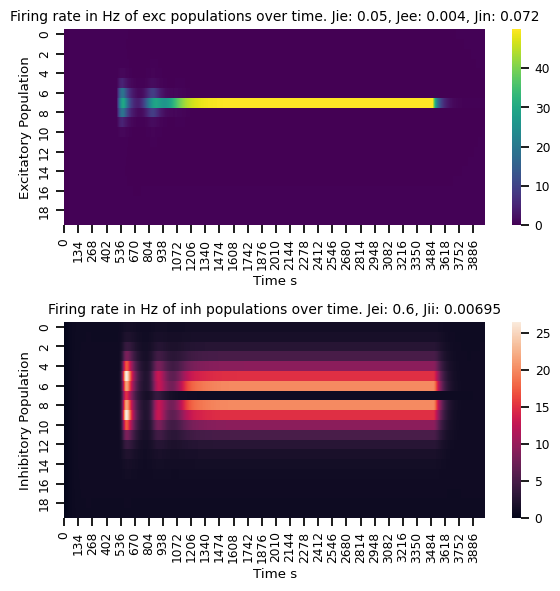

In [123]:
J = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
mymodel = MyModel(param, simu, **J)
mymodel.Jdic = J
print(mymodel.Jdic['Jee'])
#print(stim.In)

In = stim.In
sti = torch.tensor(In).float() #torch.tensor(In, requires_grad = True).float()

r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt = mymodel.forward(stim = sti)


HeatMap(r_e, r_i, J)

For the 20 inputs

In [124]:
RE = torch.zeros(3999, 20 ,20)
RI = torch.zeros(3999, 20 ,20)
IN_T = torch.zeros(3999,20,20)
print(RE.shape)

for i in range(param.N):
  # \\\\\\\\\\\ Bottom up sensory input
  st = Stim(param,simu, dur=.3,f =[i], ISI=.05) #dur = 1s Isi=1s
  In, range_sim, w, sigmaIn =st.sensoryInput(param, simu, sigmaIn = 2.)
  IN_T[:,:, i] = torch.tensor(In)
  sti = torch.tensor(In).float()
  RE[:,:,i], RI[:,:,i], s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt = mymodel.forward(stim = sti)


torch.Size([3999, 20, 20])


# 1- X - train and test dataset

### Split 70% into train dataset and 30% into test dataset

In [125]:
rng = np.random.default_rng(1245)
dataset_size = (IN_T).shape[2]
rand_indices = rng.integers(low=0, high= (dataset_size-1), size=19)
#print(rng.shuffle(dataset_indices))

val_split_index = int(np.floor(0.7 * dataset_size))

test_idx, train_idx = rand_indices[val_split_index:], rand_indices[:val_split_index]

train_tensorIN = IN_T[:,:, train_idx]
test_tensorIN = IN_T[:,:, test_idx]


#2- Custom Cost function

Warning! to be integrated to the simulation, need to be updated at each time stim

## 1 Derivative part

Use the softmax function instead of RELU : smoother

In [126]:
dr_e_dt.shape

torch.Size([3999, 20])

tensor(4.)


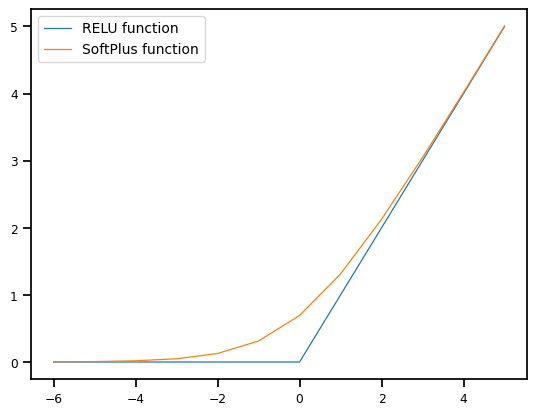

In [127]:
import torch
x = torch.arange(-6, 6)

def custom_softplus(x): # or SmoothReLU
    return np.log(1 + np.exp(x))
# OR ! torch.nn.Softplus(beta=1, threshold=20)

def custom_smooth_function(x, slope=.37, midpoint=4):
    return torch.where(x >= midpoint, x, torch.exp(slope * x))

def ELU(x, alpha):
    return torch.where(x >= 0, x, (alpha) * (torch.exp(x) - 1))

def softmax(x):
  return torch.exp(x) / torch.sum(torch.exp(x))

y =custom_smooth_function(x)
y2 = torch.relu(x)
alpha = 0.7  # Adjust the alpha value as needed
y3 = torch.add(ELU(x, alpha),.7)
y4 = custom_softplus(x)


#**************** PLOT ************************
size_axes =15
size_legend = 10
size_title =20
#~~~~~~~~~~~~~~~~~~~~~~~
"""plt.plot(x, y, linewidth = 1, label ="custom RELU function")
plt.plot(x, y3, linewidth = .9, label ="ELU function + .7")
"""
plt.plot(x, y2, linewidth = .9, label ="RELU function")
plt.plot(x, y4, linewidth = .9, label ="SoftPlus function")
plt.legend(prop = {'size': size_legend})
plt.title("")
#plt.ylim((-2, 5))
#plt.xlim((-2, 8))

print(y[10])

## 2 Probability part

  Sorry it popped into my mind but forgot to mention this: you can use softmax to get a normalised representation of your probabilities while iterpreting firing rates as logprobs, it's a built-in NN function: https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

  But no need to use it, just one more tool. I recommend you try different things (including adding some baseline value to the firing rates) see what works best.

### Try "make it proba" to "make it proba"

In [128]:
def make_it_proba(r_e):
  prob_r = torch.zeros((r_e.shape[0], r_e.shape[1])) #empty matrix initialisation
  sum_r_e = torch.sum(r_e, 1)
  torch.div(r_e, sum_r_e.resize_(r_e.shape[0],1), out = prob_r)#torch.transpose(r_e, dim0=0 ,dim1=1)
  prob_r[prob_r != prob_r] = 0.05 #to replace nan to 1/20 - to sum to 1
  #print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked

  return prob_r.resize_(r_e.shape[0],20) #log or not log?

def log_proba(proba_r):
  return torch.log(proba_r)


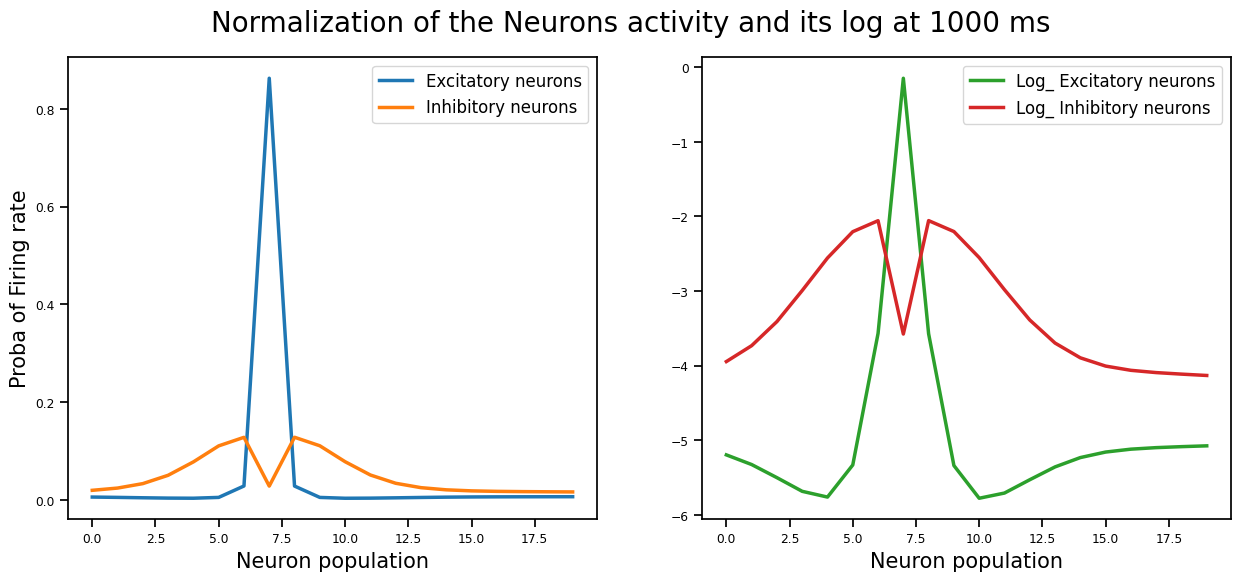

In [129]:

time = 1000
size_axes =15
size_legend = 12
size_title =20

probaRE = make_it_proba(RE[:,:,8])[time,:]
probaRI = make_it_proba(RI[:,:,8])[time,:]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 6))#, sharey = True)
ax1.plot(np.arange(0, r_e.shape[1]), probaRE, label = "Excitatory neurons")
ax1.plot(np.arange(0, r_i.shape[1]), probaRI, label = "Inhibitory neurons")

ax2.plot(np.arange(0, r_e.shape[1]), log_proba(probaRE), 'tab:green',label = "Log_ Excitatory neurons")
ax2.plot(np.arange(0, r_i.shape[1]), log_proba(probaRI), 'tab:red', label = "Log_ Inhibitory neurons")


fig.suptitle(f"Normalization of the Neurons activity and its log at {time} ms", size = size_title, y = .96)
ax1.set_ylabel ("Proba of Firing rate", size = size_axes)
ax1.set_xlabel ("Neuron population", size = size_axes)
ax2.set_xlabel("Neuron population", size = size_axes)
ax1.legend(prop={'size': size_legend})
ax2.legend(prop={'size': size_legend})

### Try softmax to "make it proba"

In [130]:
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)
softMax_drdt = softmax(r_e) # Drdt here!
#Correct for the nan!
softMax_re = F.softmax(r_e, dim=1)
softMax_ri = F.softmax(r_i, dim=1)

print("softMax_drdt", softMax_drdt[1000,:])
#for i in range(5, 13):
 # plt.plot(torch.arange(3999), softMax_drdt[:,i], linewidth = .6)


softMax_drdt tensor([5.8069e-13, 5.6800e-13, 5.5355e-13, 5.4128e-13, 5.3681e-13, 5.6748e-13,
        1.2227e-12, 1.0000e+00, 1.2173e-12, 5.6680e-13, 5.3595e-13, 5.3989e-13,
        5.5151e-13, 5.6517e-13, 5.7695e-13, 5.8478e-13, 5.8916e-13, 5.9157e-13,
        5.9314e-13, 5.9446e-13])


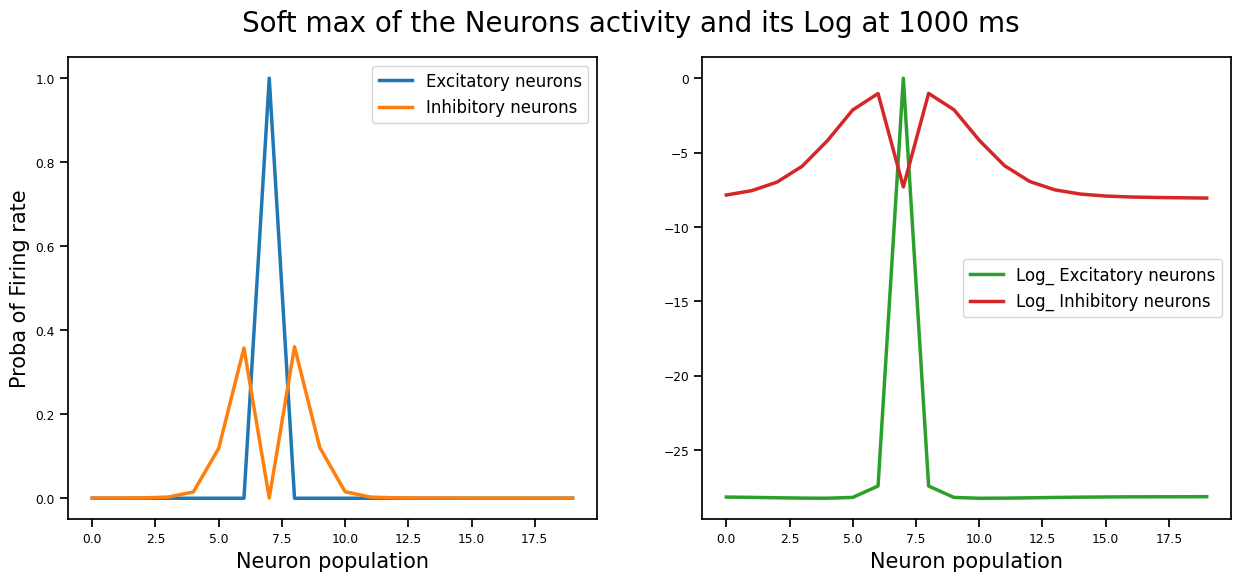

In [131]:
x = torch.arange(20)

softMax_RE = softMax_re[time, :]
softMax_RI = softMax_ri[time, :]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 6))#, sharey = True)
ax1.plot(np.arange(0, r_e.shape[1]), softMax_RE, label = "Excitatory neurons")
ax1.plot(np.arange(0, r_i.shape[1]), softMax_RI, label = "Inhibitory neurons")

ax2.plot(np.arange(0, r_e.shape[1]), log_proba(softMax_RE), 'tab:green',label = "Log_ Excitatory neurons")
ax2.plot(np.arange(0, r_i.shape[1]), log_proba(softMax_RI), 'tab:red', label = "Log_ Inhibitory neurons")


fig.suptitle(f"Soft max of the Neurons activity and its Log at {time} ms", size = size_title, y = .96)
#fig.supylabel("Proba of Firing rate hz")

ax1.set_ylabel("Proba of Firing rate", size = size_axes)
ax1.set_xlabel ("Neuron population", size = size_axes)
ax2.set_xlabel("Neuron population", size = size_axes)
ax1.legend(prop={'size': size_legend})
ax2.legend(prop={'size': size_legend})

### Add 1 everywhere in the baseline to avoid division by 0 !!! Should be in r or r proba??ß

## 3 Merging term to create Cost function

### 2D custom Loss function

In [132]:
def Dirac(A, N= param.N):
  y = scipy.signal.unit_impulse(N, idx= int(A))#, dtype= <class 'float'>)
  return y

expected_probabilities = Dirac(8)
print(expected_probabilities)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


tensor([0., 0., 0.,  ..., 0., 0., 0.])


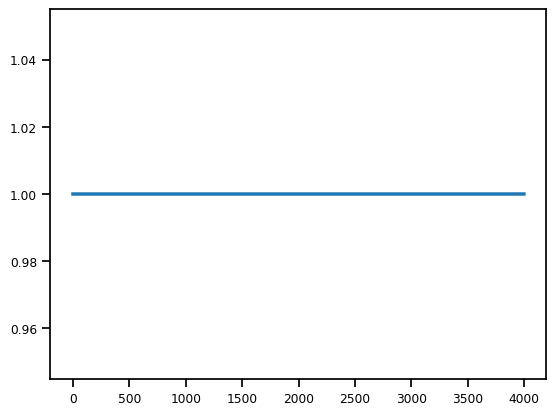

In [133]:
def get_expected_proba(r_proba, stim_f):
  r_prob_t = torch.transpose(r_proba, 0,1)
  if type(stim_f) == list: #make stim f a number
    stim_f = stim_f[0]
  else: stim_f = stim_f
  dirac_2d = torch.zeros(r_prob_t.shape) #initialize tensor

  for pop, t in enumerate(r_prob_t):
    tpop = torch.tensor(pop)
    dirac_2d[pop,:] = torch.where(tpop == stim_f, 1.0, 0.0)

  dirac_2d = torch.transpose(dirac_2d, 1,0)
  return dirac_2d


print(get_expected_proba(make_it_proba(r_e), stim.f)[:,10])
r_expected_prob = get_expected_proba(make_it_proba(r_e), stim.f)
plt.plot(torch.arange(3999),r_expected_prob[:,8])

In [134]:
expected_probabilities = torch.tensor((Dirac(8)).astype(int))
torch.empty(r_e.shape[0]).fill_(expected_probabilities[8])


tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [135]:


# MSE loss function
def mse_loss(y_pred, y_true):
    squared_error = (y_pred - y_true) ** 2
    sum_squared_error = torch.sum(squared_error, axis = 0)
    loss = sum_squared_error / y_true.shape[0]
    return loss

tensor_for_cost_derivative = dr_e_dt.clone().detach() + 1
#tensor_for_cost_derivative[:, 8] = - dr_e_dt[:, 8]
#plt.plot(tensor_for_cost_derivative[:,8])
#plt.plot(tensor_for_cost_derivative[:,5])
#torch.mean((custom_softplus(tensor_for_cost_derivative[:, 19]))**2)
#torch.mean(F.softplus(tensor_for_cost_derivative[:,19]))**2
torch.mean(F.softplus(tensor_for_cost_derivative)**2, axis =0)

r_prob = log_proba(make_it_proba(r_e) +1)
r_expected_prob = get_expected_proba(r_prob, stim.f)

#What should I use for the proba ? the mse loss ? of my custome MSE/mean?
loss_proba1 = F.mse_loss(r_prob, r_expected_prob)  # MSE loss for the stimulated population

print(sum(mse_loss(r_prob, r_expected_prob)))
print(loss_proba1)

tensor(1.2821)
tensor(0.0641)


In [136]:

def custom_loss(r_e, dr_e_dt, target_pop=8):
    #proba + base line
    r_e_prob = make_it_proba(r_e) +1
    dr_e_dt_baseline = dr_e_dt.clone().detach() + 1

    # Define your expected firing rate probability for each population
    expected_proba= Dirac(target_pop)
    r_expected_prob = get_expected_proba(r_e_prob, stim.f)
    #print(expected_proba[target_pop])

    # Apply softmax to r_e to convert it into a probability distribution or use makeitproba
    #r_proba1 = torch.log(F.softmax(r_e +1, dim=1))
    r_proba = torch.log(r_e_prob)

    # Calculate loss by comparing the distribution to the expected probabilities
    #loss_proba = F.mse_loss(r_proba, r_expected_prob)  # MSE loss #weird result need to talk with alex
    loss_proba = torch.sum(mse_loss(r_e_prob, r_expected_prob)) # using MY MSE Loss !

    # Compute Loss for derivative term
    tensor_for_cost_derivative = dr_e_dt_baseline.clone().detach()
    tensor_for_cost_derivative[:, target_pop] = - dr_e_dt_baseline[:, target_pop] #we want it to be negative for the stimulated population
    loss_derivative = torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative)**2, axis = 0))

    Total_loss = loss_derivative + loss_proba
    return Total_loss

In [137]:
custom_loss(r_e,dr_e_dt)

tensor(1095473.8750)

In [138]:
target_pop = stim.f[0]
class Custom_Loss(torch.nn.Module):
    def __init__(self):
        super(Custom_Loss,self).__init__()

    def forward(self,r_e,dr_e_dt): #x, y maybe instead of re drdt
      r_e_prob = make_it_proba(r_e +1)
      dr_e_dt_baseline = dr_e_dt.clone().detach() + 1

      # Define your expected firing rate probability for each population
      expected_proba= Dirac(target_pop)
      r_expected_prob = get_expected_proba(r_e_prob, stim.f)
      #print(expected_proba[target_pop])

      # Apply softmax to r_e to convert it into a probability distribution or use makeitproba
      #r_proba1 = torch.log(F.softmax(r_e +1, dim=1))
      r_proba = torch.log(r_e_prob)

      # Calculate loss by comparing the distribution to the expected probabilities
      #loss_proba = F.mse_loss(r_proba, r_expected_prob)  # MSE loss #weird result need to talk with alex
      loss_proba = torch.sum(mse_loss(r_e_prob, r_expected_prob)) # using MY MSE Loss !

      # Compute Loss for derivative term
      tensor_for_cost_derivative = dr_e_dt_baseline.clone().detach()
      tensor_for_cost_derivative[:, target_pop] = - dr_e_dt_baseline[:, target_pop] #we want it to be negative for the stimulated population
      loss_derivative = torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative)**2, axis = 0))

      Total_loss = loss_derivative + loss_proba
      return Total_loss

Try making this custom loss a class from torch.nn.module

### 1D Custom loss , get expected proba or make it proba for every time step, for 1d **array**

In [139]:
def get_expected_proba_1D(r_proba, stim_f):
  if type(stim_f) == list: #make stim f a number
    stim_f = stim_f[0]
  else: stim_f = stim_f
  dirac_1d = torch.zeros(r_proba.shape) #initialize tensor

  for pop in enumerate(r_proba):
    dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim.f[0]), torch.tensor(1.0),torch.tensor(0.0))
  return dirac_1d

In [140]:
def make_it_proba_1D(r_e):
  #prob_r = torch.zeros((r_e.shape[0], r_e.shape[1])) #empty matrix initialisation
  prob_r = torch.zeros(r_e.shape)
  sum_r_e = torch.sum(r_e)
  torch.div(r_e, sum_r_e, out = prob_r)#torch.transpose(r_e, dim0=0 ,dim1=1)
  #prob_r[prob_r != prob_r] = 0.05 #to replace nan to 1/20 - to sum to 1 # instad add baseline of 1

  #print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked

  return prob_r #prob_r.resize_(r_e.shape[0],20) #log or not log?

def log_proba(proba_r):
  return torch.log(proba_r)


In [141]:
target_pop = stim.f[0]
class Custom_Loss_1D(torch.nn.Module):
    def __init__(self):
        super(Custom_Loss_1D,self).__init__()

    def forward(self,r_e,dr_e_dt): #x, y maybe instead of re drdt
      r_e_prob = make_it_proba_1D(r_e +1)
      #dr_e_dt_baseline = dr_e_dt.clone().detach()

      # Define your expected firing rate probability for each population
      #expected_proba= Dirac(target_pop)
      r_expected_prob = get_expected_proba_1D(r_e_prob, stim.f)
      #print(expected_proba[target_pop])

      # Apply softmax to r_e to convert it into a probability distribution or use makeitproba
      #r_proba1 = torch.log(F.softmax(r_e +1, dim=1))
      r_proba = torch.log(r_e_prob)

      # Calculate loss by comparing the distribution to the expected probabilities
      #loss_proba = F.mse_loss(r_proba, r_expected_prob)  # MSE loss #weird result need to talk with alex
      loss_proba = torch.sum(mse_loss(r_e_prob, r_expected_prob)) # using MY MSE Loss !

      # Compute Loss for derivative term
      #tensor_for_cost_derivative = dr_e_dt_baseline.clone().detach()
      tensor_for_cost_derivative[target_pop] = - dr_e_dt[target_pop] #we want it to be negative for the stimulated population
      loss_derivative = torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative)**2, axis = 0))

      Total_loss = loss_derivative + loss_proba
      return Total_loss

In [142]:
r_e_prob22 = make_it_proba_1D(r_e[1000,:] +1)
#r_e_prob22 = F.softmax(r_e[1000,:], dim =0)
dr_e_dt_baseline = dr_e_dt[1000,:].clone().detach() + 1
r_expected_prob = get_expected_proba_1D(r_e_prob22, stim.f)
print(r_e_prob22)

tensor([0.0224, 0.0219, 0.0214, 0.0210, 0.0209, 0.0219, 0.0364, 0.5552, 0.0363,
        0.0219, 0.0208, 0.0210, 0.0214, 0.0218, 0.0222, 0.0225, 0.0226, 0.0227,
        0.0228, 0.0228])


In [188]:
ok= Custom_Loss_1D()
ok.forward(r_e[10,:], dr_e_dt[10,:])

tensor(1095461.8750)

# 3 -My New model and optimization

In [144]:
criterion_loss_1D = Custom_Loss_1D()

class MyModel(nn.Module):
    def __init__(self, param, sim, **kwargs):
        super(MyModel, self).__init__()
        torch.manual_seed(2020)
        # Define other model parameters, layers, or components here if needed
        self.param = param
        self.dicJ = kwargs
        self.dt = sim.dt
        self.N = (param.N)
        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True))




    def phi(self, I_tot, a, b, hm):
        return hm * (1 / (1 + np.exp(- (a * I_tot + b))))


    def forward(self, stim):
        if type(stim) == torch.Tensor:
          In = stim
        else:
          In = stim.In #stim.In@weight
          In = (torch.tensor(In).float()) #, requires_grad = True).float())
        # Initialize model variables here
        r_e = torch.zeros((In.shape[0]),(self.N)) #, requires_grad=True)
        r_i = torch.zeros(In.shape[0], self.N) #, requires_grad=True)
        s_ampa = torch.zeros((In.shape[0], (self.N)))
        s_gaba = torch.zeros((In.shape[0], (self.N)))
        i_tot_e = torch.zeros((In.shape[0], (self.N)))
        i_tot_i = torch.zeros((In.shape[0], (self.N)))
        dr_e_dt = torch.zeros((In.shape[0], (self.N)))
        dr_i_dt = torch.zeros((In.shape[0], (self.N)))
        CostValue= torch.zeros(1)# , requires_grad = True)


        # Perform integration over time steps
        for k in range(1, In.shape[0]):
            i_tot_e[k, :] = float(self.Jee) * torch.FloatTensor(s_ampa[k - 1, :]) - float(self.Jie) * torch.FloatTensor(torch.matmul(s_gaba[k - 1, :].float(), (self.param.wie).float())) + float(self.Jin) * In[k-1,:] #(torch.tensor(In[k-1,:], requires_grad = True).float()
            i_tot_i[k, :] = self.Jei * torch.matmul(s_ampa[k - 1, :], (self.param.wei).float()) - self.Jii * torch.matmul(s_gaba[k - 1, :].float(), (self.param.wii).float())

            phi_arr_e = self.phi(i_tot_e[k, :].detach().numpy(), self.param.ae, self.param.be, self.param.hme)
            phi_arr_i = self.phi(i_tot_i[k, :].detach().numpy(), self.param.ai, self.param.bi, self.param.hmi)

            dr_e_dt[k, :]  = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue
            dr_i_dt[k, :]  = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

            r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :]  * self.dt
            r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :]  * self.dt

            dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
            s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
            s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

            #CostValue += custom_loss(r_e[k,:], dr_e_dt[k,:])
            CostValue += criterion_loss(r_e[k,:], dr_e_dt[k,:])
            #CostValue += criterion_loss.forward(r_e[k,:], dr_e_dt[k,:])

        return r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt,CostValue

[8]


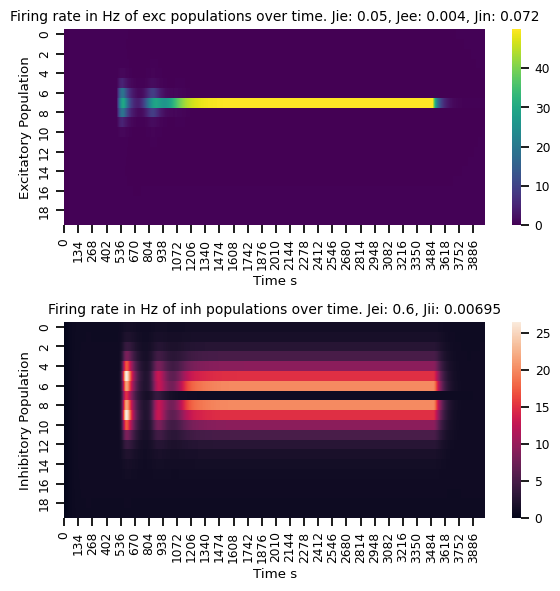

In [145]:
J = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
mymodel2 = MyModel(param, simu, **J)
mymodel2.Jdic = J
#print(mymodel2.Jdic['Jee'])
#print(stim.In)
print(stim.f)

In = stim.In
sti = torch.tensor(In).float() #torch.tensor(In, requires_grad = True).float()

r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt, CostValue = mymodel2.forward(stim = sti)


HeatMap(r_e, r_i, J)

In [189]:
# At each time step!!!!!!!!!!!!!!!!

criterion_loss_1D = Custom_Loss_1D()

class MyModel3(nn.Module):
    def __init__(self, param, sim, **kwargs):
        super(MyModel3, self).__init__()
        torch.manual_seed(2020)
        # Define other model parameters, layers, or components here if needed
        self.param = param
        self.dicJ = kwargs
        self.dt = sim.dt
        self.N = (param.N)
        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True))




    def phi(self, I_tot, a, b, hm):
        return torch.multiply(hm, torch.divide(1, (1 + torch.exp(- (torch.multiply(a, I_tot) + b)))))
        #return hm * (1 / (1 + torch.exp(- (a * I_tot + b))))


    def forward(self, stim, k):
        if type(stim) == torch.Tensor:
          In = stim
        else:
          In = stim.In #stim.In@weight
          In = (torch.tensor(In).float()) #, requires_grad = True).float())
        # Initialize model variables here
        r_e = torch.zeros((In.shape[0], self.N)) #, requires_grad=True)
        new_r_e = torch.zeros((In.shape[0],self.N), requires_grad=True) #, requires_grad=True)
        r_i = torch.zeros((In.shape[0], self.N)) #, requires_grad=True)
        s_ampa = torch.zeros((In.shape[0], (self.N)))
        s_gaba = torch.zeros((In.shape[0], (self.N)))
        i_tot_e = torch.zeros((In.shape[0], (self.N)))
        i_tot_i = torch.zeros((In.shape[0], (self.N)))
        dr_e_dt = torch.zeros((In.shape[0], (self.N)))
        new_dr_e_dt = torch.zeros((In.shape[0], (self.N)), requires_grad=True)
        dr_i_dt = torch.zeros((In.shape[0], (self.N)))
        #CostValue= torch.zeros(1)# , requires_grad = True)


        # Perform integration over time steps

        i_tot_e[k, :] = float(self.Jee) * torch.FloatTensor(s_ampa[k - 1, :]) - float(self.Jie) * torch.FloatTensor(torch.matmul(s_gaba[k - 1, :].float(), (self.param.wie).float())) + float(self.Jin) * In[k-1,:] #(torch.tensor(In[k-1,:], requires_grad = True).float()
        i_tot_i[k, :] = self.Jei * torch.matmul(s_ampa[k - 1, :], (self.param.wei).float()) - self.Jii * torch.matmul(s_gaba[k - 1, :].float(), (self.param.wii).float())

        phi_arr_e = self.phi(i_tot_e[k, :], self.param.ae, self.param.be, self.param.hme)#.detach().numpy()
        phi_arr_i = self.phi(i_tot_i[k, :], self.param.ai, self.param.bi, self.param.hmi)#.detach().numpy()

        dr_e_dt[k, :]  = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue
        dr_i_dt[k, :]  = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

        r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :]  * self.dt
        r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :]  * self.dt

        dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
        s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

        dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
        s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

        new_dr_e_dt = dr_e_dt
        new_r_e = r_e
        #CostValue += criterion_loss(new_r_e[k,:], new_dr_e_dt[k,:])
        #CostValue += criterion_loss(r_e[k,:], dr_e_dt[k,:])

        #CostValue += custom_loss(r_e[k,:], dr_e_dt[k,:])
        #CostValue += criterion_loss.forward(r_e[k,:], dr_e_dt[k,:])

        return r_e, r_i, dr_e_dt, dr_i_dt,new_r_e, new_dr_e_dt

In [147]:
#mymodel3.forward(sti, 1000)

# Optimzation

In [165]:
# MLE
def MLE_Norm(parameters):
  if type(parameters) == np.ndarray: #numpy.float64:#:list:  #np.ndarray:
    m = float(parameters[0])
    s = float(parameters[1])
  else:
    m = float(parameters)# float(parameters[0])
    s = .1

  y_pred = norm.pdf(x, m, s)

  standard_dev = .1
  LL = np.sum(norm.logpdf(y, y_pred, standard_dev))
  neg_LL = -1*LL
  #print(neg_LL)

  return neg_LL #neg log likelihood pdf

# 4) Initialise model and optimizer

In PyTorch, nn.Parameter is typically used to create and specify trainable parameters that are updated during the optimization process. These parameters are initialized with random values or specific initializations and are part of the model's learnable parameters. You cannot directly create nn.Parameter objects from dictionaries or arbitrary variables like dicJ.

In [190]:
# Initialize the model, loss function, and the SGD optimizer

# +++++++++++++++++++++++++ Model ++++++++++++++++++++++++++++
J = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
mymodel3 = MyModel3(param, simu, **J) #these ** pass J as an unpacked dict, not as a single positional argument

mymodel3.Jdic = J
print(mymodel.Jdic['Jee'])
#print(stim.In)


# +++++++++++++++++++++++++ Optimizer ++++++++++++++++++++++++++++
optimizer = optim.SGD(mymodel3.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(mymodel3.parameters(), lr=0.01)
#optimizer = optim.Adam(mymodel3.parameters(), lr=0.05)

# +++++++++++++++++++++++++ Loss ++++++++++++++++++++++++++++
#criterion = Custom_Loss()
criterion_loss_1D = Custom_Loss_1D()
#loss_fn = nn.MSELoss()

0.072


In [191]:
#data
Y_data = r_e #r_e_prob #
In = stim.In
#X = sti = torch.tensor(In).float() #torch.tensor(In, requires_grad = True).float()
X = sti = make_it_proba(torch.tensor(In).float())

With MLE

# 5) Training Loop

I have to put the temporal loop outside since I want to compute the loss at each time step. But I want to optimize it outside the temporal loop! ???

model(X) vs model.forward(X) explained here: https://medium.com/jun94-devpblog/pytorch-2-a043b216fb29

In [194]:
##### test with changin oreder of zero grad and total loss etc

num_epochs = 5  # Define the number of training epochs
losses = np.zeros(num_epochs)
CostValue= torch.zeros(1)# , requires_grad = True)


# Forward pass to compute the loss
for epoch in range(num_epochs):
  total_loss = 0.0
  optimizer.zero_grad()  # Zero the gradients
  r_e, r_I, dr_e_dt, dr_i_dt,new_r_e, new_dr_e_dt  = mymodel3(X, 0) #initialize?
  for t in range(1, In.shape[0]):
      r_e, r_I, dr_e_dt, dr_i_dt,new_r_e, new_dr_e_dt = mymodel3(X, t)
      #print(prediction[9].shape)
      #loss = CostValue#.requires_grad_(True)
      #loss = criterion(r_e, dr_e_dt).requires_grad_(True)
      # Backward pass and optimization
      #print(r_e.grad)
      CostValue += criterion_loss_1D(new_r_e[t,:], new_dr_e_dt[t,:])
      #print(CostValue)
      total_loss += CostValue #loss.item()


  total_loss = (total_loss).requires_grad_(True)
  total_loss.backward()
  print("total_loss.grad: ",total_loss.grad, "r_e.grad", new_r_e.grad,"dr_e_dt.grad", new_dr_e_dt.grad)
  for par in mymodel.parameters():
    print(par.grad)
  optimizer.step()
  losses[epoch] = total_loss.item()
  # Print the current loss for monitoring
  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item()}')
  #CostValue.item()

total_loss.grad:  tensor([1.]) r_e.grad None dr_e_dt.grad None
None
None
None
None
None
Epoch [1/5], Loss: 8756985331712.0
total_loss.grad:  tensor([1.]) r_e.grad None dr_e_dt.grad None
None
None
None
None
None
Epoch [2/5], Loss: 26268401664000.0
total_loss.grad:  tensor([1.]) r_e.grad None dr_e_dt.grad None
None
None
None
None
None
Epoch [3/5], Loss: 43781747376128.0
total_loss.grad:  tensor([1.]) r_e.grad None dr_e_dt.grad None
None
None
None
None
None
Epoch [4/5], Loss: 61295105671168.0
total_loss.grad:  tensor([1.]) r_e.grad None dr_e_dt.grad None
None
None
None
None
None
Epoch [5/5], Loss: 78808455577600.0


In [84]:

num_epochs = 5  # Define the number of training epochs
losses = np.zeros(num_epochs)

# Forward pass to compute the loss
for epoch in range(num_epochs):
  total_loss = 0.0
  for t in range(1, In.shape[0]):
      optimizer.zero_grad()  # Zero the gradients
      r_e, r_I, dr_e_dt, dr_i_dt, CostValue = mymodel3(X, t)
      #print(prediction[9].shape)
      loss = CostValue.requires_grad_(True)
      #loss = criterion(r_e, dr_e_dt).requires_grad_(True)
      # Backward pass and optimization
      loss.backward()
      total_loss += loss.item()

  optimizer.step()
  print(loss.grad)
  losses[epoch] = loss.item()
  # Print the current loss for monitoring
  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


tensor([1.])
None
Epoch [1/5], Loss: 4947.71044921875
tensor([1.])
None
Epoch [2/5], Loss: 4947.71044921875
tensor([1.])
None
Epoch [3/5], Loss: 4947.71044921875
tensor([1.])
None
Epoch [4/5], Loss: 4947.71044921875
tensor([1.])
None
Epoch [5/5], Loss: 4947.71044921875


In [158]:
num_epochs = 5  # Define the number of training epochs
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):


    # Forward pass to compute the loss
    #r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt, CostValue = mymodel.forward(stim)
    r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt, CostValue = mymodel(X)
    #print(prediction[9].shape)
    loss = CostValue#.requires_grad_(True)
    #loss = criterion(r_e, dr_e_dt).requires_grad_(True)

    # Backward pass and optimization
    optimizer.zero_grad()  # Zero the gradients
    loss.backward()
    optimizer.step()

    losses[epoch] = loss.item()
     # Print the current loss for monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    """
    loss = CostValue  # You can change this to your custom loss function

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print the current loss for monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')"""

Epoch [1/5], Loss: 191483968.0
Epoch [2/5], Loss: 191483968.0
Epoch [3/5], Loss: 191483968.0
Epoch [4/5], Loss: 191483968.0
Epoch [5/5], Loss: 191483968.0


In [ ]:
print(prediction[0]).shape

In [ ]:
init_params = [1, .1]#, .1]

niter = 10
for _ in range(0, niter):
  # initialize gradient
  optimizer.zero_grad()

  #Forward Pass
  predictions = mymodel(X) #not my Model.forward!
  y_pred_prob = make_it_proba(predictions[0])
  y = y_pred_prob[1000,:]

  #Expected distribution
  #re_prob_t = torch.transpose(r_e_prob, 0,1)
  y_expect = torch.tensor(expected_dirac(y))

  #Minimize - log likelihood of the gaussian model for the y distribution
  mle_model_TNC = minimize(MLE_Norm, init_params, bounds= [(0,20), (0.01, 6)],method='TNC',tol=1e-6)#, callback=callback2)#,tol=1e-6, callback=callback)
  y_pred_TNC = norm.pdf(x, mle_model_TNC.x[0], mle_model_TNC.x[1])



  #Compute MSE between y and expected distribution
  #MCE_value = MSE(y_pred_TNC)
  #Loss = MSE(y_pred_TNC).requires_grad_(True)

  #here use my loss!!
  Loss = loss_fn(y, y_expect).requires_grad_(True)
  #Compute the gradient and optimize it
  Loss.backward()

  optimizer.step()
  Jin = list(mymodel.parameters())[4].item()
  print("Jin", Jin)
  print("-" * 10)
  print("error = {}".format(Loss))


: Train the model by iteratively updating its parameters to minimize the custom loss function.

In [ ]:
num_epochs = 1000
##!!!! normalise to range between 0 and 1 the firing rate before doing the loss

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero gradients
    loss_sensitive = custom_loss(dr_e_dt.requires_grad_(), r_e, param.N, 'stim.f')
    loss_others = custom_loss(dr_e_dt.requires_grad_(), r_e,param.N, None)
    Total_loss = loss_sensitive + loss_others
    Total_loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters

In [ ]:
#other instance of stim
def get_In_stim(frequency):
  stim2 = Stim(param,simu, f=[frequency], dur=.3, ISI=.05) #dur = 1s Isi=1s
  In2, range_sim, w, sigmaIn =stim2.sensoryInput(param, simu, sigmaIn = 2.)
  In2 = stim2.In
  sti2 = torch.tensor(In2).float()
  return sti2
#mymodel.forward(stim = sti2)

#get a stimuli sequence for a stim of "8"
sti2 = get_In_stim(8)


# Set the model to evaluation mode
mymodel.eval()

# Forward pass on validation or test data
with torch.no_grad():
    # Assuming `input_data` is your validation or test input
    output = mymodel(stim = sti2) #r_e, r_i, s_ampa, s_gaba, i_tot_e, i_tot_i, In, dr_e_dt, dr_i_dt


HeatMap(output[0], output[1], J)